# Binary Classification of Pneumonia and Normal

This project focuses on binary classification of chest X-ray images into **Pneumonia** and **Normal** categories using a **GoogleNet/InceptionNet V1** architecture with **Transfer Learning**. The goal is to maximize model performance through careful training strategies, including K-Fold cross-validation, soft voting ensembles, and post-training threshold tuning.

While we achieved strong results, key limitations include limited labeled data, class imbalance, and variations across datasets. To evaluate generalization, we tested the model on an external dataset as well. This setup helps simulate real-world performance and avoid overfitting to a single source.


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torchvision import datasets, transforms
from torchvision.models import googlenet, GoogLeNet_Weights
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import os
import random
from PIL import Image
import time
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Data Exploration & Preparation

Before training the model, we’ll perform a thorough analysis of the dataset to ensure it's suitable for our task. This includes:

- Checking image sizes to verify consistency and detect any unusually small or large images
- Analyzing class distributions to see how many images belong to each category (Normal vs Pneumonia)
- Evaluating class balance to determine if the dataset is imbalanced and whether augmentation or sampling strategies are needed

These steps will help us identify any issues early and prepare the data effectively for training.


#### Checking the image sizes of each dataset


In [38]:
main_folder = "/kaggle/input/chest-xray-pneumonia/chest_xray"
image_size = {}
size = []

# getting the train/test/val set
for dataset in ['train', 'val', 'test']:  
    set_path = os.path.join(main_folder, dataset)

     # getting the class
    for label in ['NORMAL', 'PNEUMONIA']: 
        img_folder = os.path.join(set_path, label)

        # getting the images
        for filename in os.listdir(img_folder):
            img_path = os.path.join(img_folder, filename)
            with Image.open(img_path) as img:
                size.append(img.size)

        image_size[dataset + '/' + label] = {
            'min': min(size, key=lambda x: x[0]*x[1]),
            'max': max(size, key=lambda x: x[0]*x[1])}

for k,v in image_size.items():
    print(f"{k} : {v}")

train/NORMAL : {'min': (912, 672), 'max': (2916, 2583)}
train/PNEUMONIA : {'min': (384, 127), 'max': (2916, 2583)}
val/NORMAL : {'min': (384, 127), 'max': (2916, 2583)}
val/PNEUMONIA : {'min': (384, 127), 'max': (2916, 2583)}
test/NORMAL : {'min': (384, 127), 'max': (2916, 2583)}
test/PNEUMONIA : {'min': (384, 127), 'max': (2916, 2583)}


#### Setting Image Transformations for GoogleNet

We chose our resizing strategy after analyzing the minimum and maximum image sizes in the dataset. This helps ensure that all images — whether very small or very large — are transformed in a way that’s safe, consistent, and compatible with GoogleNet’s input requirements.


In [39]:
transform_GNet = transforms.Compose([
    # converting our grayscale x-rays to RGB
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(         
        mean=[0.485, 0.456, 0.406],    
        std=[0.229, 0.224, 0.225]
    )
])

In [40]:
train_dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

In [41]:
train_dataset = datasets.ImageFolder(train_dataset_path, transform = transform_GNet)
train_dataset.classes

['NORMAL', 'PNEUMONIA']

In [42]:
val_dataset = datasets.ImageFolder(val_dataset_path, transform = transform_GNet)

In [43]:
train_dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

Checking the size of each class and examining any one random image from each


In [44]:
Counter(train_dataset.targets)

Counter({0: 1341, 1: 3875})

#### The Train Set is Not Balanced

We'll be using Augmentor to perform augmentation and balancing at the same time.

#### Augmentation Strategy

Instead of only augmenting the minority NORMAL class, I chose to apply light augmentation to NORMAL and stronger augmentation to PNEUMONIA.
This helps balance the dataset and improves generalization, especially for pneumonia cases that may appear in varied forms.

In medical tasks like this, false negatives are more dangerous than false positives. So by making the PNEUMONIA class more diverse with controlled augmentations, the model can better learn to detect it in real-world situations.

#### Safe Augmentations Used

Since we’re working with chest X-rays, we’ll stick to safe and medically reasonable transformations:

- Brightness/Contrast (small changes)
- RandomRotation (±10°)
- Zooming in (very slight, preserves full anatomy)


reference used for augmentation: https://youtu.be/mygPhlH8un0?si=ZuaWM-hD-SMlUmZP


In [45]:
!pip install Augmentor

In [46]:
import Augmentor

In [47]:
# for our NORMAL class
output_dir = "/kaggle/working/NORMAL_augmented"
os.makedirs(output_dir, exist_ok=True)
normal_aug = Augmentor.Pipeline("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL",
                                output_directory = output_dir,
                                save_format = "jpeg")

# brightness/contrast: 90% - 110% 
# randomly applying slight brightness or contrast changes
# to make the model robust to real-world variations 
normal_aug.random_brightness(probability=0.5, min_factor=0.9, max_factor=1.1)  
normal_aug.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.1)

# adding 3534 more images to make the dataset balanced  
normal_aug.sample(3534)  

Initialised with 1341 image(s) found.
Output directory set to /kaggle/working/NORMAL_augmented.

Processing <PIL.Image.Image image mode=L size=1874x1836 at 0x7A2E3B841190>: 100%|██████████| 3534/3534 [01:04<00:00, 55.11 Samples/s]                   


In [48]:
# for our PNEUMONIA class (adding a bit more variations)
output_dir = "/kaggle/working/PNEUMONIA_augmented"
os.makedirs(output_dir, exist_ok=True)
pneumonia_aug = Augmentor.Pipeline("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA",
                                   output_directory = output_dir,
                                   save_format = "jpeg")

# brightness/contrast: 85% - 115% 
pneumonia_aug.random_brightness(probability=0.7, min_factor=0.85, max_factor=1.15)
pneumonia_aug.random_contrast(probability=0.7, min_factor=0.85, max_factor=1.15)

# rotation is also kept minimal of about ±10°
pneumonia_aug.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

# zoom factor is also minimal to avoid losing much information
# between 10% and 20%
pneumonia_aug.zoom(probability=0.6, min_factor=1.1, max_factor=1.2)
pneumonia_aug.sample(1000)  # adding 1000 more images


Initialised with 3875 image(s) found.
Output directory set to /kaggle/working/PNEUMONIA_augmented.

Processing <PIL.Image.Image image mode=L size=1360x816 at 0x7A2F1B86ABD0>: 100%|██████████| 1000/1000 [00:27<00:00, 35.72 Samples/s]                  


#### Merging the original and augmented images


In [49]:
normal_merge = "/kaggle/working/NORMAL_merged"
pneumonia_merge = "/kaggle/working/PNEUMONIA_merged"
os.makedirs(normal_merge, exist_ok = True)
os.makedirs(pneumonia_merge, exist_ok = True)

In [50]:
import shutil

for label in ['NORMAL','PNEUMONIA']:
    aug_source_dir = "/kaggle/working/" + label + "_augmented"
    orig_source_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/" + label
    dest_dir = "/kaggle/working/" + label + "_merged"

    # moving the augmented images
    for new_img in os.listdir(aug_source_dir):
        src = os.path.join(aug_source_dir, new_img)
        dest = os.path.join(dest_dir, new_img)
        shutil.move(src, dest)

    # copying the original images
    for img in os.listdir(orig_source_dir):
        src = os.path.join(orig_source_dir, img)
        dest = os.path.join(dest_dir, img)
         # to avoid permission errors of kaggle/input we're using copy
        shutil.copy(src, dest)  

print("images moved successfully!")

images moved successfully!


In [51]:
shutil.rmtree("/kaggle/working/NORMAL_augmented")
shutil.rmtree("/kaggle/working/PNEUMONIA_augmented")

In [52]:
output_dir = "/kaggle/working/trainSet"
os.makedirs(output_dir, exist_ok = True)

shutil.move(normal_merge, output_dir)
shutil.move(pneumonia_merge, output_dir)

'/kaggle/working/trainSet/PNEUMONIA_merged'

In [53]:
new_train_path = "/kaggle/working/trainSet"
new_train_dataset = datasets.ImageFolder(new_train_path, transform=transform_GNet)
Counter(new_train_dataset.targets)

Counter({0: 4875, 1: 4875})

#### Now our training set is balanced!


## Using Another Dataset as Tester

The original test set provided with our main dataset was too small to provide a meaningful evaluation of our model's performance. To overcome this limitation, we used a **separate chest X-ray dataset** as our external test set.

This allowed us to evaluate how well our model generalizes to unseen data from a different source, helping verify its real-world applicability. The new test set included both Normal and Pneumonia cases, giving us a more reliable and diverse benchmark for final performance metrics.


In [54]:
output_dir = "/kaggle/working/testSet"
os.makedirs(output_dir, exist_ok = True)

shutil.copytree("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal", os.path.join(output_dir, "Normal"))
shutil.copytree("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia",  os.path.join(output_dir, "Pneumonia"))

shutil.rmtree("/kaggle/working/testSet/Normal/masks")
shutil.rmtree("/kaggle/working/testSet/Pneumonia/masks")

In [55]:
test_path = "/kaggle/working/testSet"
test_dataset = datasets.ImageFolder(test_path, transform=transform_GNet)
Counter(test_dataset.targets)

Counter({0: 10192, 1: 1345})

We're undersampling the Normal class because it has way more images (10,192) compared to the Viral Pneumonia class (1,345). Since we’re only using this data for testing, we want the model to be evaluated fairly on both classes.

If we kept the Normal class much larger, the model might get biased and perform well just by predicting “Normal” most of the time. That would give a misleading accuracy.

So, by reducing the Normal samples to match the Viral class, we create a balanced test set — this helps us measure how well the model performs on each class equally.


In [56]:
normal_dir = '/kaggle/working/testSet/Normal/images'
viral_dir = '/kaggle/working/testSet/Pneumonia/images'

# target number = match minority class
target = len(os.listdir(viral_dir))

# get list of normal images
normal_images = os.listdir(normal_dir)
random.shuffle(normal_images)

# keep only the first `target` images
keep = set(normal_images[:target])

for img in normal_images:
    if img not in keep:
        os.remove(os.path.join(normal_dir, img))

In [57]:
test_path = "/kaggle/working/testSet"
test_dataset = datasets.ImageFolder(test_path, transform=transform_GNet)
Counter(test_dataset.targets)

Counter({0: 1345, 1: 1345})

In [58]:
testing_loader = DataLoader(test_dataset, batch_size = 32)

Now our Testing set is prepared!


## Preparing our Validation Set

To ensure a reliable evaluation after training, we created a separate validation set ahead of time. This was done by combining 200 images per class from the test set with the original validation set, resulting in a balanced set of approximately **434 Normal** and **590 Pneumonia** images.

This validation set was **not used during training** — instead, K-Fold cross-validation was applied on the training set to train the models. The prepared validation set was reserved for **post-training fine-tuning**, such as **threshold selection** and **soft-voting ensemble evaluation**.


In [59]:
# checking our validation set
Counter(val_dataset.targets)

Counter({0: 234, 1: 390})

In [60]:
import os, random, shutil

output_dir = "/kaggle/working/valSet"
os.makedirs(output_dir, exist_ok=True)

for label in ['Normal', 'Pneumonia']:
    new_source_dir = "/kaggle/working/testSet/" + label + "/images"
    orig_source_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/" + label.upper()
    dest_dir = "/kaggle/working/valSet/" + label
    os.makedirs(dest_dir, exist_ok=True)

    # moving approx 200 images from testSet to valSet
    images = os.listdir(new_source_dir)
    random.shuffle(images)
    keep = set(images[:200])

    for img in images:
        if img in keep:
            src = os.path.join(new_source_dir, img)
            dest = os.path.join(dest_dir, f"test_{img}")
            shutil.move(src, dest)

    # copy Kaggle original val images into valSet
    for img in os.listdir(orig_source_dir):
        src = os.path.join(orig_source_dir, img)
        dest = os.path.join(dest_dir, f"val_{img}")
        shutil.copy(src, dest)

print("Images moved successfully!")

Images moved successfully!


In [61]:
val_path = "/kaggle/working/valSet"
val_dataset = datasets.ImageFolder(val_path, transform=transform_GNet)
Counter(val_dataset.targets)

Counter({0: 434, 1: 590})

In [62]:
final_val_loader = DataLoader(val_dataset, batch_size = 32)

In [63]:
# refreshing the test set
test_path = "/kaggle/working/testSet"
test_dataset = datasets.ImageFolder(test_path, transform=transform_GNet)
Counter(test_dataset.targets)

Counter({0: 1145, 1: 1145})

In [64]:
testing_loader = DataLoader(test_dataset, batch_size = 32)

## Shift to K-Fold Cross Validation

As mentioned we had switched to 3-Fold Cross Validation using only the train_dataset.
This helped us:

- Avoid overfitting to one small validation set
- Train on a wider variety of samples
- Pick the 3 best-performing models across different folds

## Focus on Recall

During training, the main focus was on maximizing recall, because missing even a single pneumonia case was considered riskier than false positives.
So even if precision dropped slightly during training, high recall was prioritized to catch as many pneumonia cases as possible.

This method is performed below:


## Transfer Learning on GoogleNet


In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [66]:
def create_model():
    weights = GoogLeNet_Weights.DEFAULT
    GNet = googlenet(weights=weights)

    # Freeze all layers first
    for param in GNet.parameters():
        param.requires_grad = False

    # Unfreeze the fully connected layers
    for name, module in GNet.named_children():
        if name == 'fc':
            for param in module.parameters():
                param.requires_grad = True

    # Update the final FC layer for binary classification
    GNet.fc = nn.Linear(GNet.fc.in_features, 1)

    # Move to device and prepare optimizer/loss
    GNet = GNet.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, GNet.parameters()), lr=1e-4)
    loss_func = nn.BCEWithLogitsLoss()

    return GNet, optimizer, loss_func

In [31]:
# # Storing Training Stats
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []
# precisions = []
# recalls = []
# f1_scores = []

In [32]:
def Train_model(model, e, fold_no, train_loader, val_loader, optimizer, loss_func):
    counter = 0
    patience = 7
    best_score = 0

    for epoch in range(e):
        model.train()
        total_loss = 0
        train_total = 0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.unsqueeze(1).float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = torch.round(torch.sigmoid(outputs))
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            total_loss += loss.item()

        train_accuracy = train_correct / train_total * 100
        train_losses.append(total_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_total_loss = 0
        pred_classes = []
        actual_classes = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
                outputs = model(images)
                loss = loss_func(outputs, labels)
                val_total_loss += loss.item()
                predicted = torch.round(torch.sigmoid(outputs))

                pred_classes.extend(predicted.cpu().numpy())
                actual_classes.extend(labels.cpu().numpy())

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total * 100
        precision = precision_score(actual_classes, pred_classes)
        recall = recall_score(actual_classes, pred_classes)
        f1 = f1_score(actual_classes, pred_classes)

        val_losses.append(val_total_loss)
        val_accuracies.append(val_accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"Epoch: {epoch+1}, Train Loss: {total_loss:.2f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Loss: {val_total_loss:.2f}, "
              f"Val Acc: {val_accuracy:.2f}%")
        print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

        current_score = (recall + val_accuracy / 100) / 2
        

        if current_score > best_score:
            best_score = current_score
            scores.append(best_score)
            counter = 0
            torch.save(model.state_dict(), f"best_model_{fold_no}.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break


### Training Code


In [33]:
# scores = []
# n = 3
# kfolds = KFold(n_splits = n, shuffle = True, random_state = 42)

# # tracking the total time
# total_training_time = 0

# for fold, (train_idx, val_idx) in enumerate(kfolds.split(new_train_dataset)):
#     print(f"\n--- Fold {fold+1} ---")
    
#     # Create subset samplers
#     train_subset = Subset(new_train_dataset, train_idx)
#     val_subset = Subset(new_train_dataset, val_idx)
    
#     train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

#     # Re-initializing the model
#     GNet, optimizer, loss_func = create_model() 

#     # measuring time
#     start = time.time()
#     # Training the model on this fold
#     Train_model(GNet, 30, fold+1, train_loader, val_loader, optimizer, loss_func)
#     end = time.time()

#     fold_time = end - start
#     total_training_time += fold_time
    
# # printing the total time it took 
# print(f"\nTotal training time for all folds: {total_training_time:.2f} seconds")


--- Fold 1 ---


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 167MB/s] 


Epoch: 1, Train Loss: 125.51, Train Acc: 72.69%, Val Loss: 53.38, Val Acc: 90.40%
Precision: 0.90, Recall: 0.90, F1: 0.90
Epoch: 2, Train Loss: 97.78, Train Acc: 88.80%, Val Loss: 42.37, Val Acc: 92.46%
Precision: 0.93, Recall: 0.92, F1: 0.92
Epoch: 3, Train Loss: 82.18, Train Acc: 89.29%, Val Loss: 35.77, Val Acc: 92.92%
Precision: 0.93, Recall: 0.92, F1: 0.93
Epoch: 4, Train Loss: 72.08, Train Acc: 90.57%, Val Loss: 31.46, Val Acc: 93.02%
Precision: 0.93, Recall: 0.93, F1: 0.93
Epoch: 5, Train Loss: 66.24, Train Acc: 90.77%, Val Loss: 28.95, Val Acc: 92.98%
Precision: 0.91, Recall: 0.95, F1: 0.93
Epoch: 6, Train Loss: 60.57, Train Acc: 91.54%, Val Loss: 26.51, Val Acc: 93.35%
Precision: 0.96, Recall: 0.90, F1: 0.93
Epoch: 7, Train Loss: 57.92, Train Acc: 91.29%, Val Loss: 24.80, Val Acc: 93.54%
Precision: 0.93, Recall: 0.94, F1: 0.94
Epoch: 8, Train Loss: 54.78, Train Acc: 91.63%, Val Loss: 23.60, Val Acc: 93.72%
Precision: 0.94, Recall: 0.93, F1: 0.94
Epoch: 9, Train Loss: 52.66, Tr

### Downloading best models


In [38]:
# # downloading the best model
# from IPython.display import FileLink
# FileLink(r'training_stats_GNet.pkl')

/kaggle/working/training_stats_GNet.pkl

In [37]:
# # saving our training Stats
# import pickle

# with open("/kaggle/working/training_stats_GNet.pkl", "wb") as f:
#     pickle.dump({
#         'scores': scores,
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'train_accuracies': train_accuracies,
#         'val_accuracies': val_accuracies,
#         'precisions': precisions,
#         'recalls': recalls,
#         'f1_scores': f1_scores,
#         'training_time': total_training_time
#     }, f)


In [69]:

# # Loading the lists
# with open("/kaggle/input/gnet-best-model-states/training_stats_GNet.pkl", "rb") as f:
#     stats = pickle.load(f)

# # Assigning back to variables
# scores = stats['scores']
# train_losses = stats['train_losses']
# val_losses = stats['val_losses']
# train_accuracies = stats['train_accuracies']
# val_accuracies = stats['val_accuracies']
# precisions = stats['precisions']
# recalls = stats['recalls']
# f1_scores = stats['f1_scores']

## Analyzing our Training through various plots


### 1. Plot Loss (Train vs Validation)


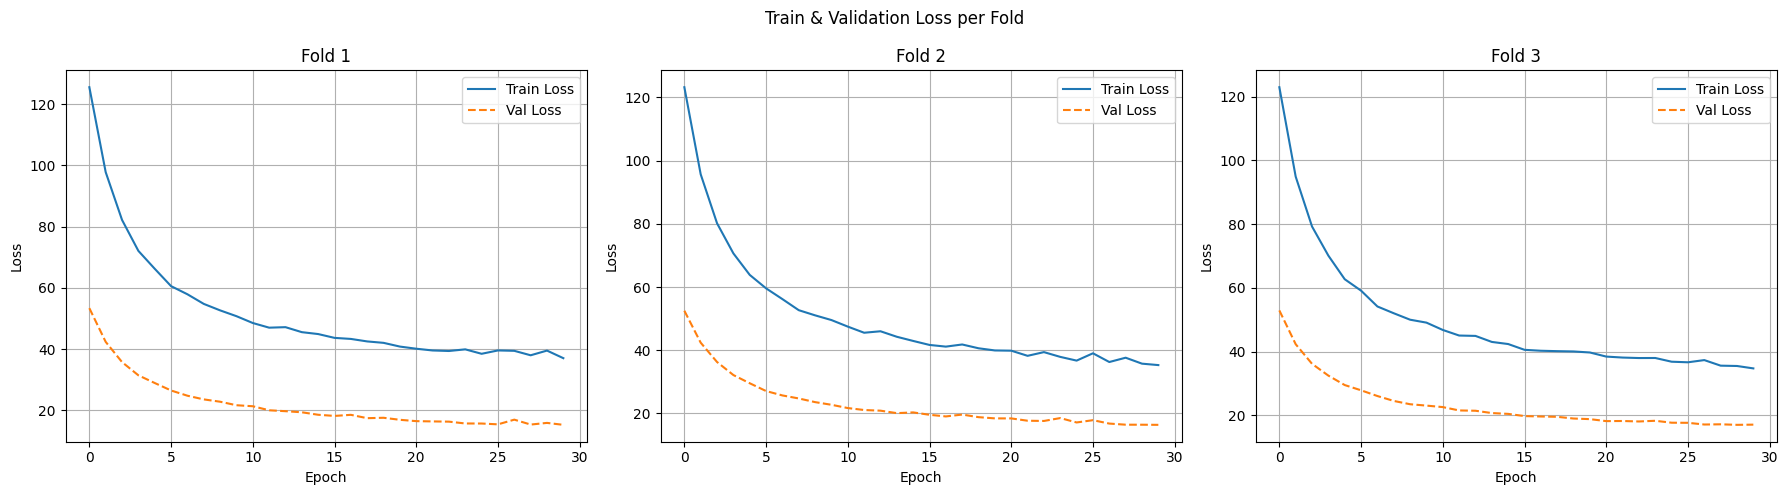

In [70]:
train_folds = []
val_folds = []

for i in range(3):
    start = i * 30
    end = start + 30
    train_folds.append(train_losses[start:end])
    val_folds.append(val_losses[start:end])

# from the above code we'll get:
# train_folds[0] → fold 1
# train_folds[1] → fold 2
# train_folds[2] → fold 3 same for val_losses

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i in range(3):
    axes[i].plot(train_folds[i], label='Train Loss')
    axes[i].plot(val_folds[i], label='Val Loss', linestyle='--')
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle('Train & Validation Loss per Fold')
plt.tight_layout()
plt.show()


### 2. Plot Accuracy (Train vs Validation)


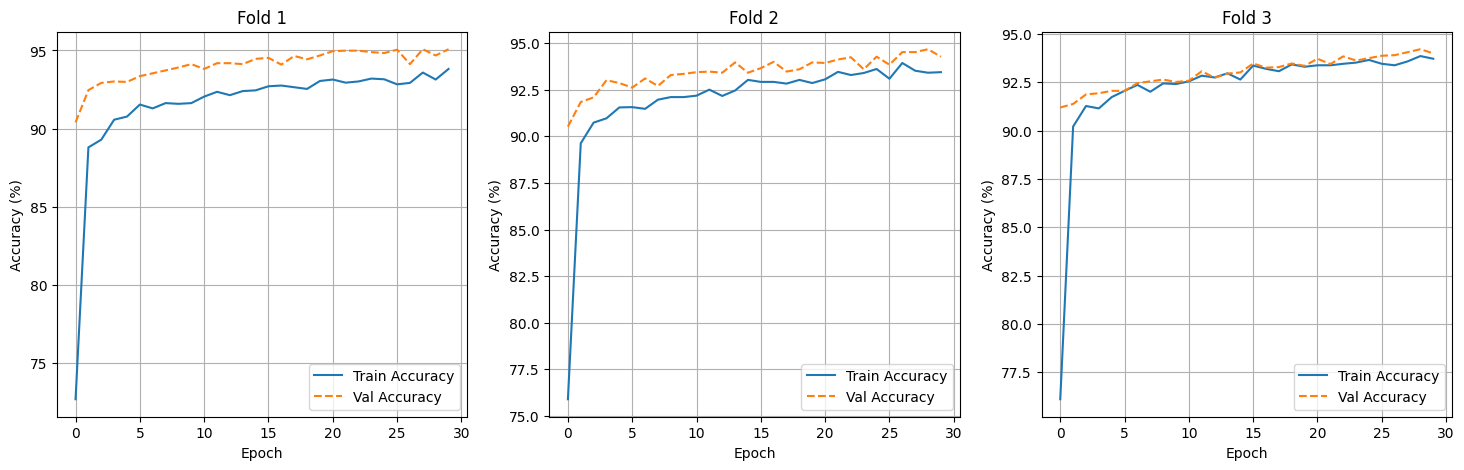

In [71]:
# splitting the accuracies similar to the loss
train_acc_folds = []
val_acc_folds = []

for i in range(3):
    start = i * 30
    end = start + 30
    train_acc_folds.append(train_accuracies[start:end])
    val_acc_folds.append(val_accuracies[start:end])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i in range(3):
    axes[i].plot(train_acc_folds[i], label='Train Accuracy')
    axes[i].plot(val_acc_folds[i], label='Val Accuracy', linestyle='--')
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy (%)')
    axes[i].legend()
    axes[i].grid(True)

## Loading all the Three best models


In [73]:
device = torch.device('cpu')  # just to be safe

best_model_1, _, _ = create_model()
best_model_1.load_state_dict(torch.load('/kaggle/input/gnet-best-model-states/best_model_1.pth', map_location=device))
best_model_1.to(device)

best_model_2, _, _ = create_model()
best_model_2.load_state_dict(torch.load('/kaggle/input/gnet-best-model-states/best_model_2.pth', map_location=device))
best_model_2.to(device)

best_model_3, _, _ = create_model()
best_model_3.load_state_dict(torch.load('/kaggle/input/gnet-best-model-states/best_model_3.pth', map_location=device))
best_model_3.to(device)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## Fine-tuning our Threshold Value for Soft Voting

Once the 3 best models were selected:

- Their predictions were soft-voted (i.e., averaged their output probabilities)
- We'll be using our validation set to fine-tune the decision threshold

The results can be seen below:


In [74]:
def get_probabilities(model1, model2, model3, dataloader):
    model1.eval()
    model2.eval()
    model3.eval()

    pred_probs = []
    actual_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
    
            # getting predicted probabilities from all 3 models
            p1 = torch.sigmoid(model1(images))
            p2 = torch.sigmoid(model2(images))
            p3 = torch.sigmoid(model3(images))
    
            final_pred = (p1+p2+p3) / 3.0
    
            # updating our lists
            pred_probs.extend(final_pred.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    return np.array(pred_probs), np.array(actual_labels)

In [75]:
pred_prob, actual_labels = get_probabilities(best_model_1, best_model_2,
                                            best_model_3, final_val_loader)

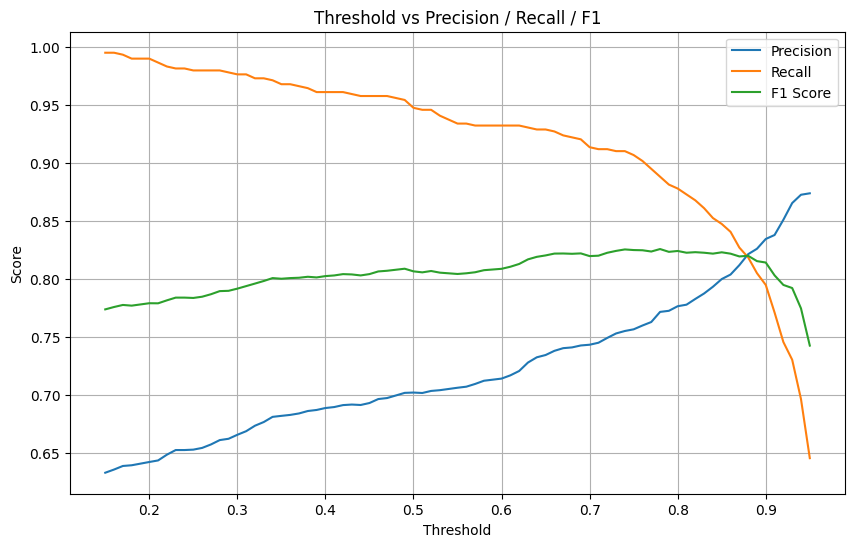

In [76]:
thresholds = np.arange(0.15, 0.96, 0.01)

precisions = []
recalls = []
f1s = []

for th in thresholds:
    preds = (pred_prob > th).astype(int)
    precisions.append(precision_score(actual_labels, preds))
    recalls.append(recall_score(actual_labels, preds))
    f1s.append(f1_score(actual_labels, preds))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision / Recall / F1')
plt.legend()
plt.grid(True)
plt.show()


In [80]:
test_pred, test_actual_labels = get_probabilities(best_model_1, best_model_2,
                                                 best_model_3, testing_loader)
Final_prediction = (test_pred > 0.83).astype(int)

acc = accuracy_score(test_actual_labels, Final_prediction)
precision = precision_score(test_actual_labels, Final_prediction)
recall = recall_score(test_actual_labels, Final_prediction)
f1 = f1_score(test_actual_labels, Final_prediction)

print(f"Accuracy: {acc*100:.4f}")
print(f"Precision: {precision*100:.4f}")
print(f"Recall: {recall*100:.4f}")
print(f"F1 Score: {f1*100:.4f}")

Accuracy: 63.5808
Precision: 59.4991
Recall: 85.0655
F1 Score: 70.0216


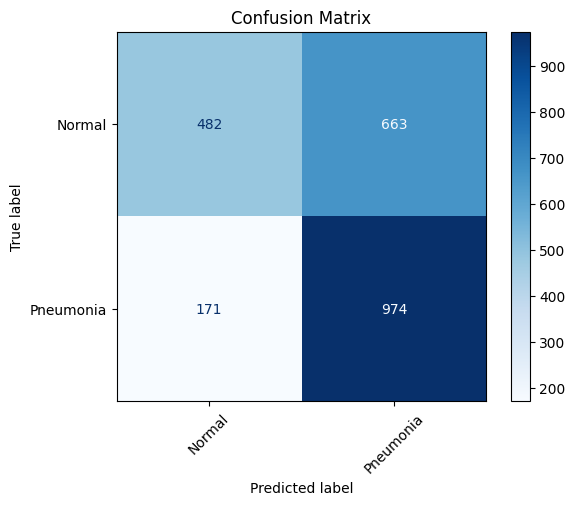

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_actual_labels, Final_prediction)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=['Normal', 'Pneumonia'])
display.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")

plt.show()

## Final Test Evaluation

After experimenting with multiple threshold tuning strategies, the final ensemble model achieved the following performance on the test set:

- Accuracy: 63.5808
- Precision: 59.4991
- Recall: 85.0655
- F1 Score: 70.0216

These results indicate a strong recall for detecting pneumonia, which was the primary objective of the model. The trade-off was a slightly reduced precision, meaning more healthy patients were incorrectly flagged. However, in a medical context where missing a pneumonia case is riskier than flagging a healthy one, this is an acceptable and intentional compromise.

The final threshold was selected using a Threshold vs Precision / Recall / F1 Score plot, which helped visualize the trade-offs across a range of thresholds (0.15 to 0.95). While the F1 score technically peaked at 0.89, this came at the cost of a significant drop in recall — which was not acceptable for our use case. To maintain a high recall while still improving overall balance, we selected a threshold of 0.83, where recall remained strong and F1 score was still high. This threshold offered the most practical compromise for our final model.


## Limitations and Future Improvements

Despite the promising validation metrics, test performance was comparatively lower. This is likely due to a distribution shift between the training and test datasets, especially since the test set was sourced from a different dataset with variations in image format (e.g., PNG vs. JPEG), contrast, and structure. Such domain differences often cause models to generalize poorly, even if validation results are strong.

- To address this gap, future work can explore:
- Data normalization across datasets to reduce domain shift
- Domain adaptation techniques or adversarial training
- Advanced augmentation strategies to increase robustness
- Fine-tuning deeper layers of pretrained networks
- Using more diverse and representative training data

Overall, while performance on the unseen test set was modest, the model showed clear potential — especially in recall — and provides a strong baseline for future improvements.


In [36]:
# # code to clear up the output folders

# import shutil
# import os

# working_dir = "/kaggle/working"

# for item in os.listdir(working_dir):
#     item_path = os.path.join(working_dir, item)
#     try:
#         if os.path.isdir(item_path):
#             shutil.rmtree(item_path)
#         else:
#             os.remove(item_path)
#     except Exception as e:
#         print(f"Couldn't delete {item_path}: {e}")
